In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)


Bad key savefig.frameon in file C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


In [4]:
cad_jpy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7929 entries, 1990-01-02 to 2020-06-04
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   7929 non-null   float64
 1   Open    7929 non-null   float64
 2   High    7929 non-null   float64
 3   Low     7929 non-null   float64
dtypes: float64(4)
memory usage: 309.7 KB


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD_Yen_Exchange_Rate'}, xlabel='Date'>

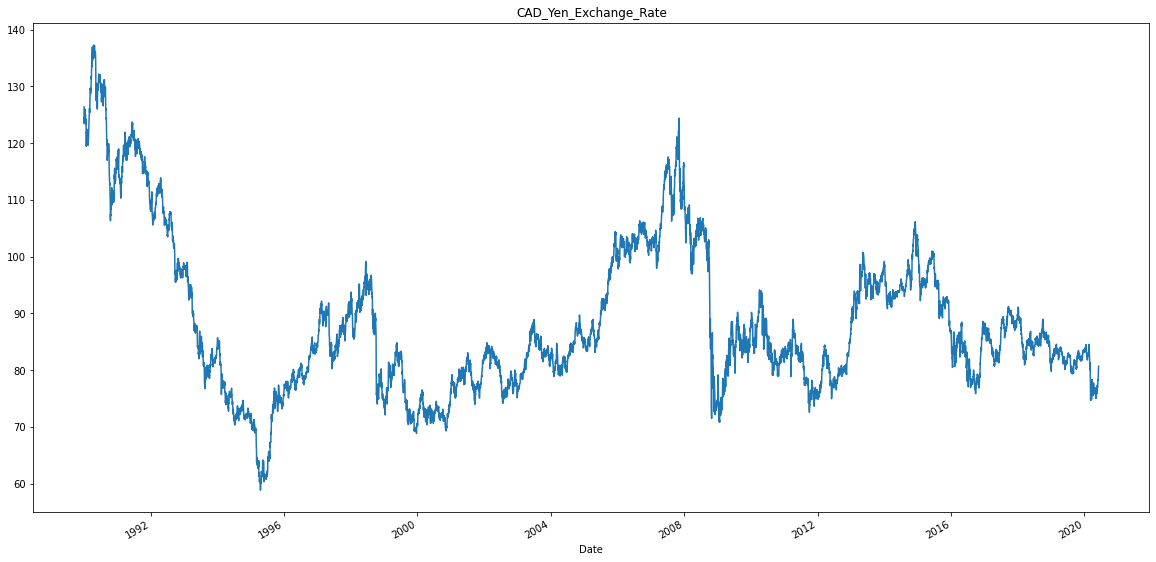

In [5]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(20,10),title='CAD_Yen_Exchange_Rate')

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** From a visual analysis, it appears there has been times between 1990-96, 2006-08, and 2013-16 where there are drastic price movements. In general, the price data appears to be trending down whichi indicates that the Canadian Dollar is increasing in value faster than the Japanese Yen.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [7]:
cad_jpy_noise.head()

Date
1990-01-02    0.519095
1990-01-03   -0.379684
1990-01-04   -2.048788
1990-01-05   -0.798304
1990-01-08   -0.897037
Name: Price_cycle, dtype: float64

In [8]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
trend_analysis = pd.DataFrame({
    'Price': cad_jpy_df['Price'], 
    'Trend': cad_jpy_trend, 
    'Noise': cad_jpy_noise
})

In [9]:
trend_analysis.head()

,Price,Trend,Noise
Date,,,
1990-01-02,126.37,125.850905,0.519095
1990-01-03,125.30,125.679684,-0.379684
1990-01-04,123.46,125.508788,-2.048788
1990-01-05,124.54,125.338304,-0.798304
1990-01-08,124.27,125.167037,-0.897037


<AxesSubplot:xlabel='Date'>

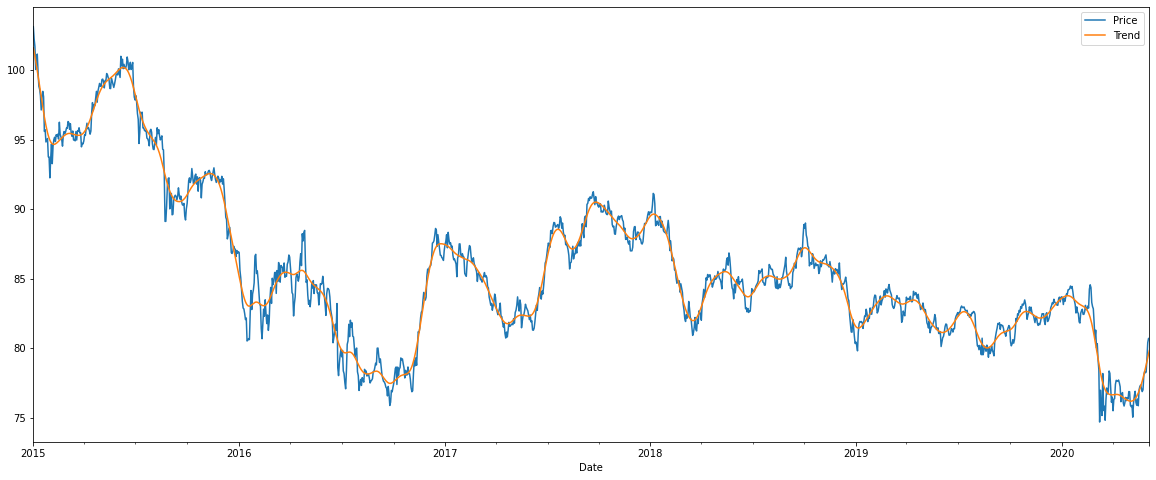

In [10]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
trend_price_plot = trend_analysis.drop(columns='Noise')
trend_price_plot['2015':].plot(figsize=(20,8))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** I see a downward trending pattern in the long-term. in the short term, it seems the price data is trending up which may present an opportunity to buy.

<AxesSubplot:xlabel='Date'>

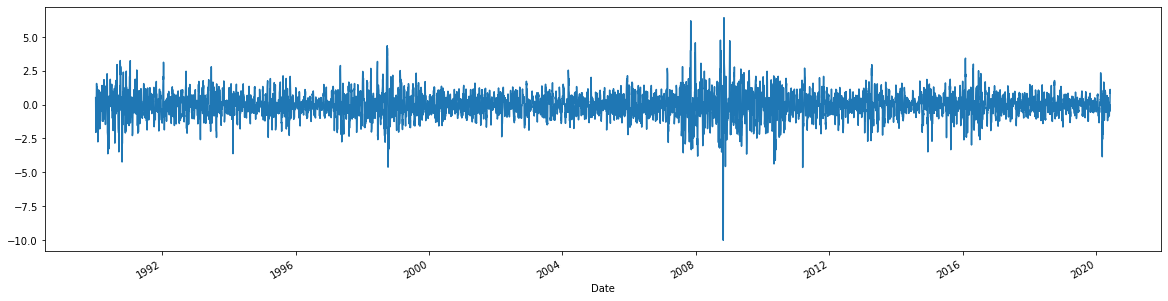

In [11]:
# Plot the Settle Noise
trend_analysis.Noise.plot(figsize=(20,5))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [13]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sun, 01 May 2022   AIC                          19513.955
Time:                        14:52:44   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1707           +0.0000j           42.1707            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Currency Exchange Forecast'}>

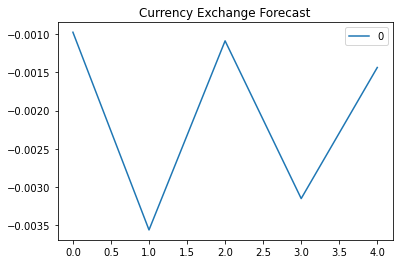

In [15]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Currency Exchange Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The P value is 0.807 which is much higher than 0.05. Therefore any results that the model predicts should not be used because the P value findings are statistically insignificant.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(cad_jpy_df['Price'], order=(5,1,1))

#Fit the model
arima_results = arima_model.fit()


C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Rog\miniconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Sun, 01 May 2022   AIC                          17507.244
Time:                        14:52:48   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'CDN to JPY Exchange Forecast'}>

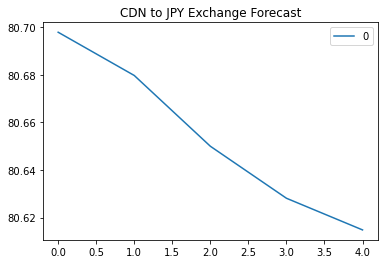

In [18]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="CDN to JPY Exchange Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The ARIMA model suggests that the exchange rate from the Candian Dollar to the Yen will decrease over time. This implies the value of the Yen will also decrease as it will become cheaper to purchase the Yen using the CAD. However, the P value, AIC, and BIC appear to be quite high so the confidence in the model is low.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

<AxesSubplot:xlabel='Date'>

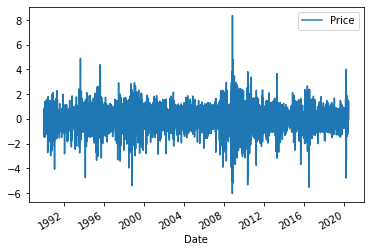

In [21]:
from arch import arch_model
#Garch Requires statinarity so we will use percent change data.
returns.pct_change()*100
returns.dropna(inplace=True)
returns.plot()

In [29]:
# Estimate a GARCH model:
gar_model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
garch_results = gar_model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 14036855.11782559
Iteration:      2,   Func. Count:     12,   Neg. LLF: 13363.554304230105
Iteration:      3,   Func. Count:     18,   Neg. LLF: 8971.890338689233
Iteration:      4,   Func. Count:     23,   Neg. LLF: 12400.209043875737
Iteration:      5,   Func. Count:     28,   Neg. LLF: 8937.28618848332
Iteration:      6,   Func. Count:     33,   Neg. LLF: 8927.170281456072
Iteration:      7,   Func. Count:     38,   Neg. LLF: 8913.03334686438
Iteration:      8,   Func. Count:     43,   Neg. LLF: 8911.021814561322
Iteration:      9,   Func. Count:     47,   Neg. LLF: 8911.021419531553
Iteration:     10,   Func. Count:     51,   Neg. LLF: 8911.020770375262
Iteration:     11,   Func. Count:     55,   Neg. LLF: 8911.020764953675
Iteration:     12,   Func. Count:     58,   Neg. LLF: 8911.020764957899
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8911.020764953675
            Iterations: 12
 

In [30]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17828.0
Method:            Maximum Likelihood   BIC:                           17849.0
                                        No. Observations:                 7928
Date:                Sun, May 01 2022   Df Residuals:                     7928
Time:                        15:01:28   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.0734e-03  2.401e-03      3.779  1.574e-04 [4.368e-03,1.378e-02]
alpha[1]       0.0624  9.003e-03      6.936  4.036e-12 [4.480e-02,8.009e-02]
beta[1]        0.9243  1.110e-02     83.252      0.000     [  0.903,  0.946]
============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [31]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [42]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(horizon=forecast_horizon, start=last_day)


In [43]:
forecasts

In [44]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566047,12.573736,12.581319,12.588797,12.596172


In [45]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566047
h.2,12.573736
h.3,12.581319
h.4,12.588797
h.5,12.596172


<AxesSubplot:>

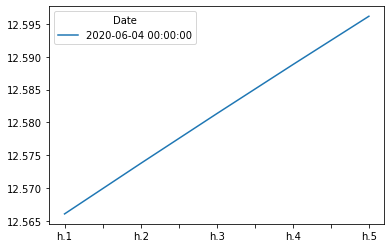

In [46]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** It appears that volatility will increase consistently in the near future.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * No, even though all the analysis do not have statistically significant P values and AIC and BIC values, all models do predict that the Yen will go decrease in value. Therefore, I have no reason to buy the Yen.

2. Is the risk of the yen expected to increase or decrease?
    * From the analyis we conducted using the GARCH model, the risk of the Yen is expected to increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I would feel confident using these models as one data point as many in making a decision to buy or sell a stock. My primary goal however would be to improve the models P values, AIC, and BIC values to a point where I can trust the models themselves. 